In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Load data
df = pd.read_csv('dialogs.txt', sep='\t', names=['question', 'answer'])
print(f'Dataframe size: {len(df)}')
df.head()

Dataframe size: 3725


,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


## Data Preprocessing

In [11]:
df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['answer tokens']=df['answer'].apply(lambda x:len(x.split()))

In [12]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

df.drop(columns=['answer tokens','question tokens'],axis=1,inplace=True)
df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['answer'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['answer'].apply(clean_text)+' <end>'

df.head(10)

,question,answer,encoder_inputs,decoder_targets,decoder_inputs
0,"hi, how are you doing?",i'm fine. how about yourself?,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem. so how have you been?,i've been great. what about you?,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i've been great. what about you?,i've been good. i'm in school right now.,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i've been good. i'm in school right now.,what school do you go to?,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to?,i go to pcc.,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc.,do you like it there?,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there?,it's okay. it's a really big campus.,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it's okay. it's a really big campus.,good luck with school.,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


In [13]:
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))

In [14]:
print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")
print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")

df.drop(columns=['question','answer','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']
df.head(10)

After preprocessing: for example ,  if your birth date is january  1  2  ,   1  9  8  7  ,  write  0  1  /  1  2  /  8  7  . 
Max encoder input length: 27
Max decoder input length: 29
Max decoder target length: 28


,encoder_inputs,decoder_targets,decoder_inputs
0,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


### Tokenization

In [15]:
vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')
vocab_size=len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 2443
['', '[UNK]', '<end>', '.', '<start>', "'", 'i', '?', 'you', ',', 'the', 'to']


In [16]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: hi , how are you ?')
print(f'Question to tokens: {sequences2ids("hi , how are you ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: hi , how are you ?
Question to tokens: [1971    9   45   24    8    7    0    0    0    0]
Encoder input shape: (3725, 30)
Decoder input shape: (3725, 30)
Decoder target shape: (3725, 30)


In [17]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [1971    9   45   24    8  194    7    0    0    0    0    0] ...
Decoder input: [  4   6   5  38 646   3  45  41 563   7   2   0] ...
Decoder target: [  6   5  38 646   3  45  41 563   7   2   0   0] ...


In [18]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 23
Number of training data: 3427
Number of validation batches: 3
Number of validation data: 447
Encoder Input shape (with batches): (149, 30)
Decoder Input shape (with batches): (149, 30)
Target Output shape (with batches): (149, 30)


## Build Model


### Build Encoder

In [19]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.05492529,  0.15266985,  0.04370199, ..., -0.08879866,
          0.22202696, -0.37017933],
        [ 0.12894006,  0.10224515, -0.06736784, ...,  0.04214153,
          0.14457445,  0.04148737],
        [-0.24272148,  0.17540565, -0.03193068, ...,  0.0260507 ,
         -0.00237005, -0.24734744],
        ...,
        [ 0.22782134, -0.05090602, -0.30386263, ...,  0.01875009,
          0.03926164,  0.14106123],
        [-0.09025598,  0.17276779,  0.05515226, ...,  0.10462641,
          0.1279037 , -0.16607006],
        [ 0.14873864,  0.21059343, -0.25664318, ...,  0.09234403,
          0.05701153,  0.0299582 ]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.11698355,  0.2801821 ,  0.08916042, ..., -0.15838134,
          0.4478261 , -0.72724086],
        [ 0.24675378,  0.18144594, -0.11442132, ...,  0.1114008 ,
          0.35674953,  0.08413847],
        [-0.6056274 ,  0.32293427, -0.06914635,

#### Build Decoder

In [20]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 2443), dtype=float32, numpy=
array([[[1.24806713e-04, 7.05349725e-04, 1.32141295e-05, ...,
         1.02151387e-06, 5.42894668e-05, 2.19893845e-04],
        [3.68122819e-05, 7.15220987e-04, 9.15452139e-04, ...,
         2.28956978e-05, 2.40401223e-05, 2.93040823e-04],
        [5.52982383e-05, 4.67358419e-04, 2.23151772e-04, ...,
         5.88133735e-05, 4.65654666e-05, 4.72281157e-04],
        ...,
        [3.37879901e-05, 3.59287951e-04, 6.96842762e-05, ...,
         2.37563181e-05, 4.74902590e-05, 2.99803971e-04],
        [3.37879901e-05, 3.59287951e-04, 6.96842762e-05, ...,
         2.37563181e-05, 4.74902590e-05, 2.99803971e-04],
        [3.37879901e-05, 3.59287951e-04, 6.96842762e-05, ...,
         2.37563181e-05, 4.74902590e-05, 2.99803971e-04]]], dtype=float32)>

### Build Training Model

In [21]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

In [22]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 30, 2443), dtype=float32, numpy=
array([[[1.24806713e-04, 7.05349725e-04, 1.32141295e-05, ...,
         1.02151387e-06, 5.42894668e-05, 2.19893845e-04],
        [3.68122819e-05, 7.15220987e-04, 9.15452139e-04, ...,
         2.28956978e-05, 2.40401223e-05, 2.93040823e-04],
        [5.52982383e-05, 4.67358419e-04, 2.23151772e-04, ...,
         5.88133735e-05, 4.65654666e-05, 4.72281157e-04],
        ...,
        [3.37879901e-05, 3.59287951e-04, 6.96842762e-05, ...,
         2.37563181e-05, 4.74902590e-05, 2.99803971e-04],
        [3.37879901e-05, 3.59287951e-04, 6.96842762e-05, ...,
         2.37563181e-05, 4.74902590e-05, 2.99803971e-04],
        [3.37879901e-05, 3.59287951e-04, 6.96842762e-05, ...,
         2.37563181e-05, 4.74902590e-05, 2.99803971e-04]],

       [[2.43271970e-05, 6.29221671e-04, 1.26887471e-05, ...,
         1.30482283e-06, 9.33110932e-05, 2.04422380e-04],
        [4.01568905e-05, 1.62811790e-04, 4.06391948e-04, ...,
         2.09070004e-05, 2

### Train Model

In [26]:
history=model.fit(
    train_data,
    epochs=25,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.5512
Epoch 1: val_loss improved from inf to 0.72636, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 66s 3s/step - loss: 0.5259 - accuracy: 0.5503 - val_loss: 0.7264 - val_accuracy: 0.4993
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 0.5180 - accuracy: 0.5537
Epoch 2: val_loss improved from 0.72636 to 0.55080, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 27s 1s/step - loss: 0.5175 - accuracy: 0.5522 - val_loss: 0.5508 - val_accuracy: 0.5560
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.5574
Epoch 3: val_loss did not improve from 0.55080
23/23 [==============================] - 21s 902ms/step - loss: 0.5158 - accuracy: 0.5565 - val_loss: 0.6149 - val_accuracy: 0.5605
Epoch 4/25
23/23 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.5592
Epoch 4: val_loss did not improve from 0.55080
23/23 [==============================] - 20s 864ms/step - loss: 0.5115 - accuracy: 0.5571 - val_loss: 0.6153 - val_accuracy: 0.5196
Epoch 5/25
23/23 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.5628
Epoch 5: val_loss did not improve from 0.55080
23/23 [==============================] - 20s 868ms/step - loss: 0.5024 - accuracy: 0.5624 - val_loss: 0.6298 - val_accuracy: 0.5284
Epoch 6/25
23/23 [==============================] - 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 32s 1s/step - loss: 0.4757 - accuracy: 0.5840 - val_loss: 0.5487 - val_accuracy: 0.5927
Epoch 12/25
23/23 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.5849 
Epoch 12: val_loss improved from 0.54868 to 0.50263, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 625s 28s/step - loss: 0.4680 - accuracy: 0.5855 - val_loss: 0.5026 - val_accuracy: 0.6120
Epoch 13/25
23/23 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.5884
Epoch 13: val_loss did not improve from 0.50263
23/23 [==============================] - 16s 695ms/step - loss: 0.4639 - accuracy: 0.5892 - val_loss: 0.6210 - val_accuracy: 0.5391
Epoch 14/25
23/23 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.5949
Epoch 14: val_loss improved from 0.50263 to 0.48408, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 31s 1s/step - loss: 0.4594 - accuracy: 0.5944 - val_loss: 0.4841 - val_accuracy: 0.5968
Epoch 15/25
23/23 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.5968
Epoch 15: val_loss did not improve from 0.48408
23/23 [==============================] - 19s 813ms/step - loss: 0.4529 - accuracy: 0.5967 - val_loss: 0.5685 - val_accuracy: 0.5877
Epoch 16/25
23/23 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.5949
Epoch 16: val_loss did not improve from 0.48408
23/23 [==============================] - 18s 772ms/step - loss: 0.4533 - accuracy: 0.5951 - val_loss: 0.5466 - val_accuracy: 0.5750
Epoch 17/25
23/23 [==============================] - ETA: 0s - loss: 0.4479 - accuracy: 0.5981
Epoch 17: val_loss did not improve from 0.48408
23/23 [==============================] - 18s 769ms/step - loss: 0.4476 - accuracy: 0.5980 - val_loss: 0.5045 - val_accuracy: 0.5749
Epoch 18/25
23/23 [===========================

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 29s 1s/step - loss: 0.4468 - accuracy: 0.5992 - val_loss: 0.4588 - val_accuracy: 0.6072
Epoch 19/25
23/23 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.6006
Epoch 19: val_loss did not improve from 0.45880
23/23 [==============================] - 20s 863ms/step - loss: 0.4460 - accuracy: 0.5997 - val_loss: 0.4683 - val_accuracy: 0.6055
Epoch 20/25
23/23 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.6031
Epoch 20: val_loss did not improve from 0.45880
23/23 [==============================] - 20s 851ms/step - loss: 0.4408 - accuracy: 0.6032 - val_loss: 0.5043 - val_accuracy: 0.5877
Epoch 21/25
23/23 [==============================] - ETA: 0s - loss: 0.4344 - accuracy: 0.6089
Epoch 21: val_loss did not improve from 0.45880
23/23 [==============================] - 20s 859ms/step - loss: 0.4356 - accuracy: 0.6081 - val_loss: 0.4799 - val_accuracy: 0.6347
Epoch 22/25
23/23 [===========================

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 32s 1s/step - loss: 0.4250 - accuracy: 0.6143 - val_loss: 0.4172 - val_accuracy: 0.6000


## Visualize Metrics

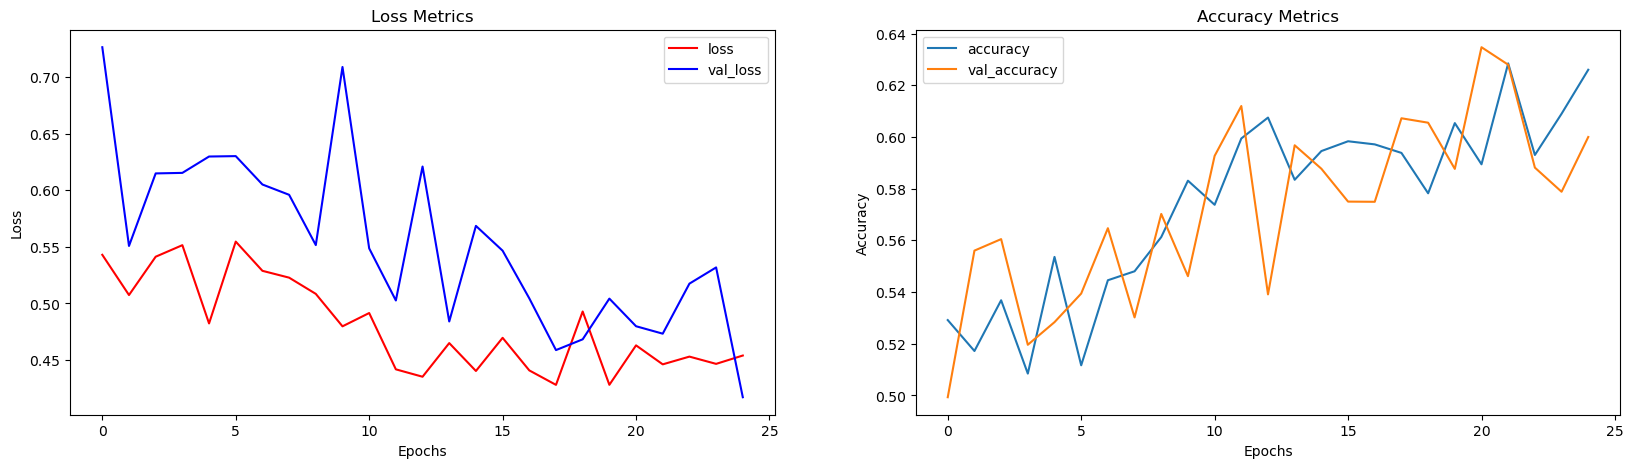

In [27]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

### Save Model

In [28]:
model.load_weights('ckpt')
model.save('models',save_format='tf')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [29]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


## Create Inference Model

In [30]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddi  (None, None, 256)         625408    
 ng)                                                             
                                                                 
 layer_normalization (Layer  (None, None, 256)         512       
 Normalization)                                                  
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1151232 (4.39 MB)
Trainable params: 1

### Time to chat

In [31]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')
        print('========================')

In [32]:
print_conversation([
    'hi',
    'do yo know me?',
    'what is your name?',
    'you are bot?',
    'hi, how are you doing?',
    "i'm pretty good. thanks for asking.",
    "Don't ever be in a hurry",
    '''I'm gonna put some dirt in your eye ''',
    '''You're trash ''',
    '''I've read all your research on nano-technology ''',
    '''You want forgiveness? Get religion''',
    '''While you're using the bathroom, i'll order some food.''',
    '''Wow! that's terrible.''',
    '''We'll be here forever.''',
    '''I need something that's reliable.''',
    '''A speeding car ran a red light, killing the girl.''',
    '''Tomorrow we'll have rice and fish for lunch.''',
    '''I like this restaurant because they give you free bread.'''
])

You: hi
Bot: i'm not right. 
You: do yo know me?
Bot: i don't know. i think it's going to be warm this weekend. 
You: what is your name?
Bot: you know what the weather is. 
You: you are bot?
Bot: i really don't know. 
You: hi, how are you doing?
Bot: i'm not sure yet. 
You: i'm pretty good. thanks for asking.
Bot: you should have been a good deal. 
You: Don't ever be in a hurry
Bot: don't get a good deal? 
You: I'm gonna put some dirt in your eye 
Bot: that's what you need to do. 
You: You're trash 
Bot: the mayor says the tv news doesn't work. 
You: I've read all your research on nano-technology 
Bot: you should have a gun. 
You: You want forgiveness? Get religion
Bot: i don't want to go to the movies tomorrow. 
You: While you're using the bathroom, i'll order some food.
Bot: i'm not going to do something. 
You: Wow! that's terrible.
Bot: yes, the snow is fun. 
You: We'll be here forever.
Bot: we'll grow old together. 
You: I need something that's reliable.
Bot: you need a car with lo